In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import RNNModel ,TFTModel
from darts.timeseries import TimeSeries

from sklearn.model_selection import ParameterGrid
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv("bike_sharing_daily (1).csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [3]:
df.shape

(731, 16)

In [4]:
df.columns 

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [5]:
df.drop(['yr','mnth','instant',
        'casual', 'registered'], axis = 1, inplace = True)

In [6]:
df.head()

,dteday,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2011-01-02,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,2011-01-03,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,2011-01-04,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,2011-01-05,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [7]:
df.rename(columns = {'dteday' : 'ds',
                    'cnt' : 'y'}, inplace = True)

In [8]:
df['ds'] = pd.to_datetime(df['ds'])

In [9]:
df = df.set_index('ds')

In [10]:
df = df.asfreq('D')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Freq: D
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   holiday     731 non-null    int64  
 2   weekday     731 non-null    int64  
 3   workingday  731 non-null    int64  
 4   weathersit  731 non-null    int64  
 5   temp        731 non-null    float64
 6   atemp       731 non-null    float64
 7   hum         731 non-null    float64
 8   windspeed   731 non-null    float64
 9   y           731 non-null    int64  
dtypes: float64(4), int64(6)
memory usage: 62.8 KB


# EDA


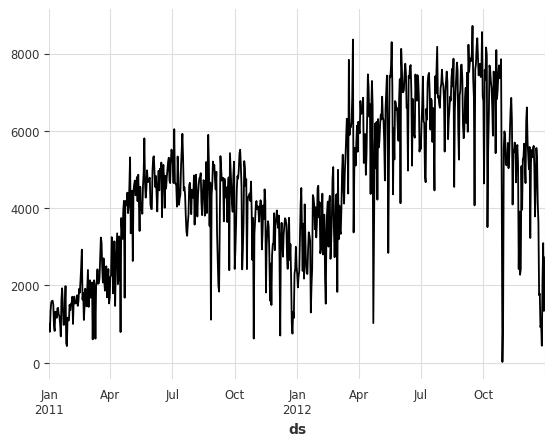

In [12]:
df['y'].plot();

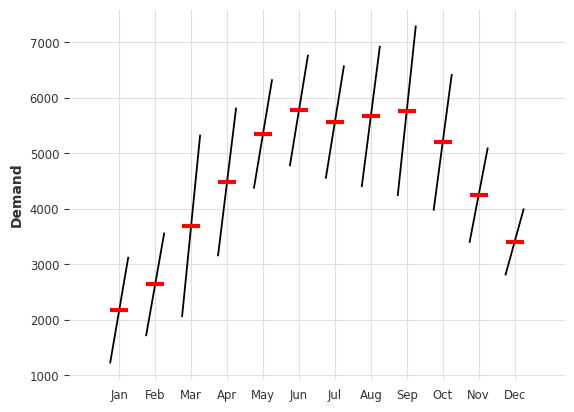

In [13]:
month_plot(df['y'].resample('ME').mean(), ylabel = "Demand")
plt.show()

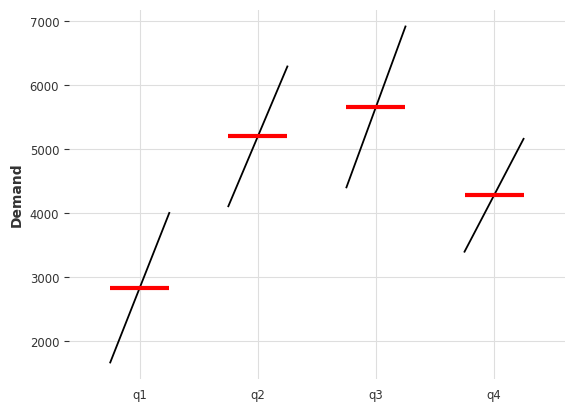

In [14]:
quarter_plot(df['y'].resample('QE').mean(), ylabel = 'Demand')
plt.show()

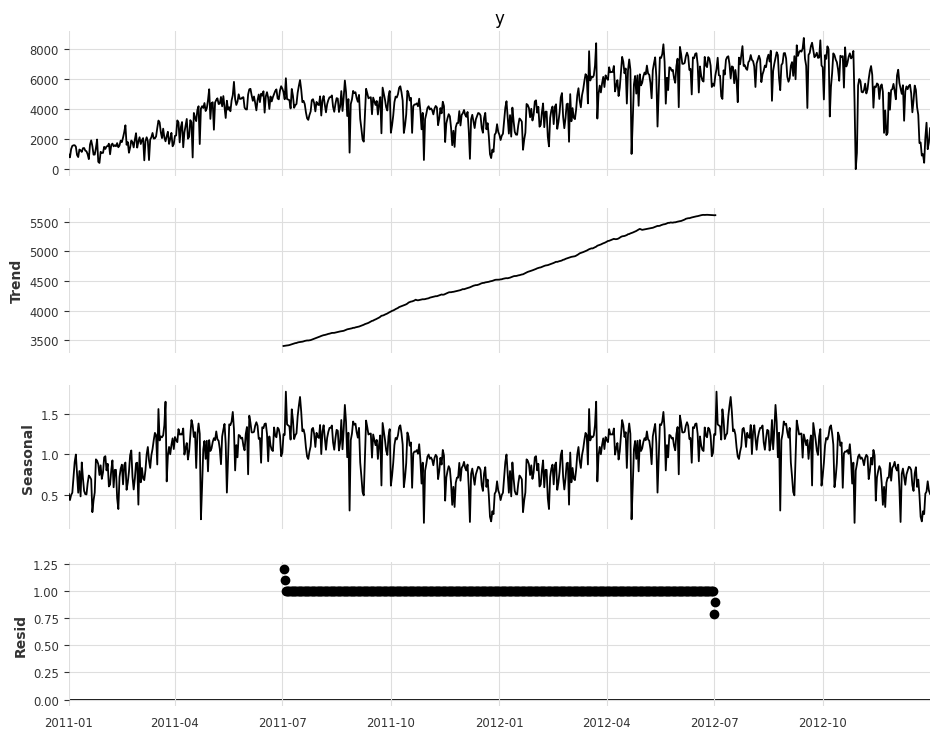

In [15]:
decomposition = seasonal_decompose(df['y'], model='mul', period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
fig.show()

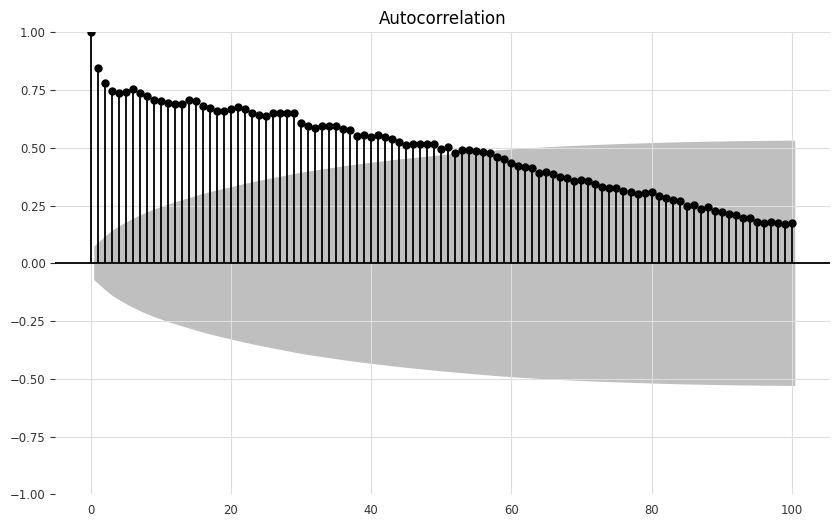

In [16]:
fig , ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags = 100 , ax= ax)
plt.show()


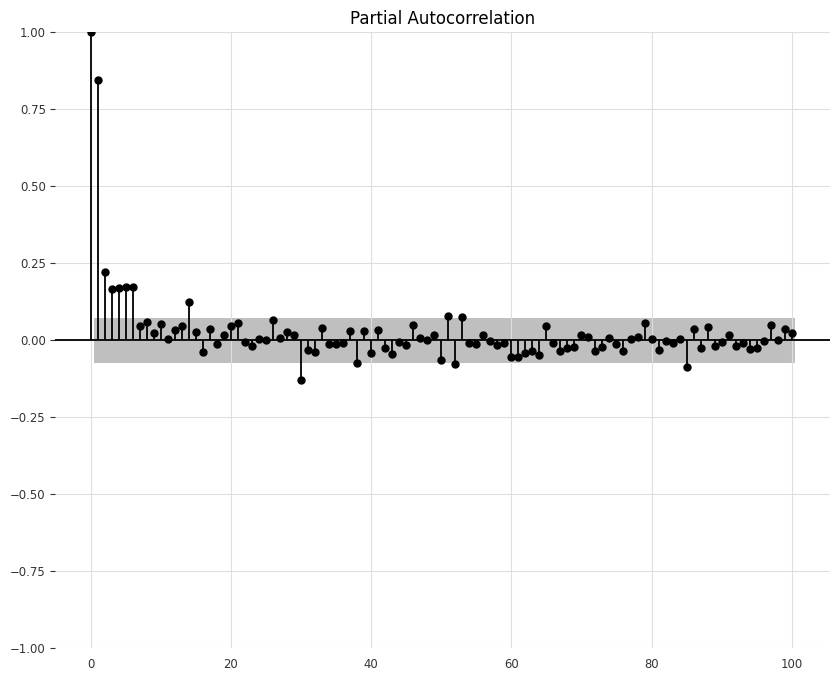

In [17]:
fig , ax = plt.subplots(figsize = (10,8))
plot_pacf(df['y'],lags = 100,  ax=ax)
plt.show()

# Preparation for model

In [18]:
type(df['y'])

pandas.core.series.Series

In [19]:
df_future = df.iloc[-31:,:]
df_future.shape

(31, 10)

In [20]:
df = df.iloc[:-31 , ]
df.shape

(700, 10)

In [21]:
series = TimeSeries.from_series(df['y'])

In [22]:
series.shape

(700, 1, 1)

In [23]:
train , val = series.split_after(pd.Timestamp("20121031"))

In [24]:
val.shape

(30, 1, 1)

In [25]:
TimeSeries.to_dataframe(train.tail())

component,y
ds,
2012-10-27,7852.0
2012-10-28,4459.0
2012-10-29,22.0
2012-10-30,1096.0
2012-10-31,5566.0


In [26]:
scaler1 = Scaler()

In [27]:
train_transformed = scaler1.fit_transform(train)
val_transformed  = scaler1.transform(val)
series_transformed = scaler1.transform(series)

In [28]:
year_series = datetime_attribute_timeseries(
    pd.date_range(start = series.start_time(),
                 freq = series.freq_str,
                 periods = 700),
    attribute = 'year',
    one_hot = False
)

year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(
    year_series,
    attribute = 'month',
    one_hot = True
)

weekday_series = datetime_attribute_timeseries(year_series,
                                             attribute = 'weekday',
                                             one_hot = True)

In [29]:
df.head()

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,y
ds,,,,,,,,,,
2011-01-01,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
2011-01-02,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2011-01-03,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
2011-01-04,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
2011-01-05,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [30]:
# Covaraites
covariates_1 = TimeSeries.from_dataframe(df.iloc[:,0:9])
covariates_transformed = Scaler().fit_transform(covariates_1)

In [31]:
covariates_2 = year_series.stack(month_series).stack(weekday_series)

In [32]:
covariates_transformed = covariates_transformed.stack(covariates_2)

In [33]:
TimeSeries.to_dataframe(covariates_transformed)

component,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,year,...,month_9,month_10,month_11,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
ds,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.0,0.0,1.000000,0.0,0.5,0.355170,0.373517,0.828620,0.284606,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-02,0.0,0.0,0.000000,0.0,0.5,0.379232,0.360541,0.715771,0.466215,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-03,0.0,0.0,0.166667,1.0,0.0,0.171000,0.144830,0.449638,0.465740,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-04,0.0,0.0,0.333333,1.0,0.0,0.175530,0.174649,0.607131,0.284297,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-01-05,0.0,0.0,0.500000,1.0,0.0,0.209120,0.197158,0.449313,0.339143,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-26,1.0,0.0,0.166667,1.0,0.0,0.316749,0.341199,0.550557,0.050010,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-11-27,1.0,0.0,0.333333,1.0,0.5,0.289752,0.265793,0.808912,0.443585,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-11-28,1.0,0.0,0.500000,1.0,0.0,0.295982,0.276562,0.520566,0.388457,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Global Models

In [34]:
# RNNModel

model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0.1,
    batch_size=30,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Air_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=20,
    force_reset=True,
    save_checkpoints=True,
)

In [35]:
model.fit(
    train_transformed,
    future_covariates = covariates_transformed,
    val_series = val_transformed,
    val_future_covariates = covariates_transformed,
    verbose = True
)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
4.2 K     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.1, training_length=20, batch_size=30, n_epochs=50, optimizer_kwargs={'lr': 0.001}, model_name=Air_RNN, log_tensorboard=True, random_state=42, input_chunk_length=20, force_reset=True, save_checkpoints=True)

In [36]:
pred_series = model.predict(n = len(val) ,
                           future_covariates = covariates_transformed)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [37]:
_ , series_transformed_slice = series_transformed.split_after(pd.Timestamp("20120901"))

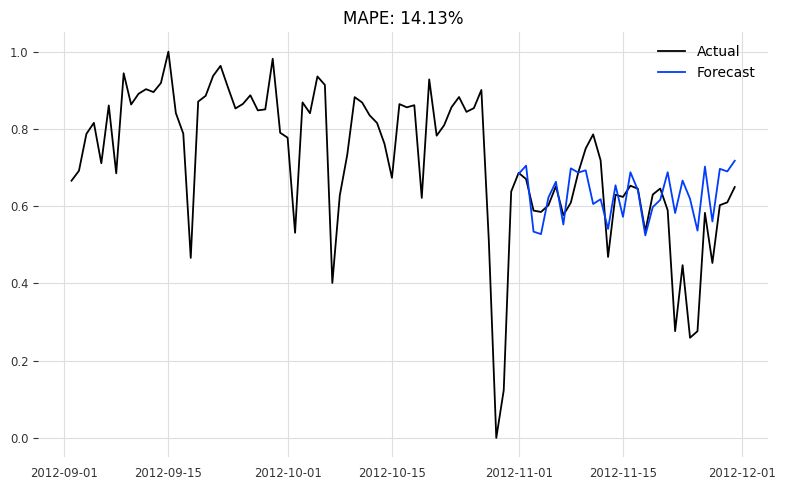

In [38]:
import matplotlib.pyplot as plt
from darts.metrics import mape

plt.figure(figsize=(8, 5))

# Plot actual values
plt.plot(series_transformed_slice.time_index, series_transformed_slice.values(), label="Actual")

# Plot forecasted values
plt.plot(pred_series.time_index, pred_series.values(), label="Forecast")

# Add title with MAPE
plt.title(f"MAPE: {mape(pred_series, val_transformed):.2f}%")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Cross Validation

In [39]:
cv = model.historical_forecasts(series = series_transformed,
                                future_covariates = covariates_transformed,
                                start = df.shape[0] -150,
                                forecast_horizon = len(val),
                                stride  = 30,
                                retrain = True,
                                last_points_only = False)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          |

Training: |          | 0/? [00:00<?, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:384: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.2 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.2 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.2 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [42]:
from sklearn.metrics import mean_squared_error

rmse_cv = []

for i in range(len(cv)):
    
    predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))
    
    start = predictions.index.min()
    end = predictions.index.max()
    actuals = df.y[start:end ,]
    
    error_cv = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_cv.append(error_cv)

print(np.mean(rmse_cv))

985.8487773967129


In [43]:
param_grid = {'n_rnn_layers' : [1,2],
             'hidden_dim' : [20],
             'dropout' : [0.1,],
             'n_epochs' : [50],
             'lr' : [0.003],
             'training_length' : [30,40], # 31+46
             'input_chunk_length' : [10,20]
             }

grid = ParameterGrid(param_grid)
len(list(grid))

8

In [52]:
# Parameter Tuning Loop

rmse = []

for params in grid:
   # Build the model
    model = RNNModel(model = 'LSTM',
                    hidden_dim = params['hidden_dim'],
                    n_rnn_layers = params['n_rnn_layers'],
                    dropout = params['dropout'],
                    n_epochs = params['n_epochs'],
                    optimizer_kwargs = {'lr' : 0.003},
                    random_state = 1502 ,
                    training_length = params['training_length'],
                    input_chunk_length = params['input_chunk_length'],
                  ) 

    
    model.fit(series_transformed, future_covariates= covariates_transformed)
    
    # Cross Validation with rollling window
    
    cv = model.historical_forecasts(series = series_transformed,
                                   future_covariates = covariates_transformed,
                                   start = df.shape[0] -180,
                                   forecast_horizon = len(val),
                                   stride = 30,
                                   retrain = True,
                                   last_points_only = False)

    rmse_cv = []
    
    for i in range(len(cv)):
    
        predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))

        # Actuals
        start = predictions.index.min()
        end = predictions.index.max()
        actuals = df.y[start:end , ]

        # Compute the error
        error_cv = np.sqrt(mean_squared_error(actuals , predictions))
        rmse_cv.append(error_cv)
        
  # Calculating and storing the error
    error = np.mean(rmse_cv)
    rmse.append(error)
        

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
3.6 K     Trainable params
0   

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | tra

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | tra

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | tra

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | tra

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [54]:
print(np.mean(rmse))

1183.7103205131555


In [55]:
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,dropout,hidden_dim,input_chunk_length,lr,n_epochs,n_rnn_layers,training_length,rmse
0,0.1,20,10,0.003,50,1,30,1192.165638
1,0.1,20,10,0.003,50,1,40,1227.534515
2,0.1,20,10,0.003,50,2,30,1086.299648
3,0.1,20,10,0.003,50,2,40,1226.919312
4,0.1,20,20,0.003,50,1,30,1193.584779
5,0.1,20,20,0.003,50,1,40,1229.378286
6,0.1,20,20,0.003,50,2,30,1082.767133
7,0.1,20,20,0.003,50,2,40,1231.033252


In [56]:
# Export the params

best_params = tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()]
best_params = best_params.iloc[0,:]
best_params.to_csv("best_params_round1.csv")

In [57]:
best_params

dropout                  0.100000
hidden_dim              20.000000
input_chunk_length      20.000000
lr                       0.003000
n_epochs                50.000000
n_rnn_layers             2.000000
training_length         30.000000
rmse                  1082.767133
Name: 6, dtype: float64

In [58]:
params_round1 = pd.read_csv("best_params_round1.csv", index_col = 0)
params_round1

,6
dropout,0.100000
hidden_dim,20.000000
input_chunk_length,20.000000
lr,0.003000
n_epochs,50.000000
n_rnn_layers,2.000000
training_length,30.000000
rmse,1082.767133


In [59]:
df_future.head()

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,y
ds,,,,,,,,,,
2012-12-01,4,0,6,0,2,0.298333,0.316904,0.806667,0.059704,5191
2012-12-02,4,0,0,0,2,0.347500,0.359208,0.823333,0.124379,4649
2012-12-03,4,0,1,1,1,0.452500,0.455796,0.767500,0.082721,6234
2012-12-04,4,0,2,1,1,0.475833,0.469054,0.733750,0.174129,6606
2012-12-05,4,0,3,1,1,0.438333,0.428012,0.485000,0.324021,5729


In [60]:
X = pd.concat([df , df_future])

In [61]:
series = TimeSeries.from_series(X['y'])
series

<TimeSeries (DataArray) (ds: 731, component: 1, sample: 1)> Size: 6kB
array([[[ 985.]],

       [[ 801.]],

       [[1349.]],

       [[1562.]],

       [[1600.]],

       [[1606.]],

       [[1510.]],

       [[ 959.]],

       [[ 822.]],

       [[1321.]],

...

       [[1749.]],

       [[1787.]],

       [[ 920.]],

       [[1013.]],

       [[ 441.]],

       [[2114.]],

       [[3095.]],

       [[1341.]],

       [[1796.]],

       [[2729.]]])
Coordinates:
  * ds         (ds) datetime64[ns] 6kB 2011-01-01 2011-01-02 ... 2012-12-31
  * component  (component) <U1 4B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [62]:
train , val = series.split_after(pd.Timestamp("20121130"))

In [83]:
train_transformed = scaler1.fit_transform(train)
val_transformed  = scaler1.transform(val)
series_transformed = scaler1.transform(series)

In [84]:
# Year 
year_series = datetime_attribute_timeseries(
    pd.date_range(start = series.start_time(),
                 freq = series.freq_str,
                 periods = X.shape[0]),
    attribute = 'year',
    one_hot = False)

year_series = Scaler().fit_transform(year_series)
# Month
month_series = datetime_attribute_timeseries(year_series,
                                            attribute = 'month',
                                            one_hot = True)

# Weekday
weekday_series = datetime_attribute_timeseries(year_series,
                                            attribute = 'weekday',
                                            one_hot = True)

In [85]:
X.head()

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,y
ds,,,,,,,,,,
2011-01-01,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
2011-01-02,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2011-01-03,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
2011-01-04,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
2011-01-05,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [86]:
covariates_1 = TimeSeries.from_dataframe(X.iloc[:,0:9])
covariates_transformed = Scaler().fit_transform(covariates_1)

In [87]:
# covariates_2 = year_series.stack(month_series)
covariates_2 = year_series.stack(month_series)

In [88]:
covariates_transformed = covariates_transformed.stack(covariates_2)

In [89]:
TimeSeries.to_dataframe(covariates_transformed)

component,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,year,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
ds,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.0,0.0,1.000000,0.0,0.5,0.355170,0.373517,0.828620,0.284606,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-02,0.0,0.0,0.000000,0.0,0.5,0.379232,0.360541,0.715771,0.466215,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-03,0.0,0.0,0.166667,1.0,0.0,0.171000,0.144830,0.449638,0.465740,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-04,0.0,0.0,0.333333,1.0,0.0,0.175530,0.174649,0.607131,0.284297,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-05,0.0,0.0,0.500000,1.0,0.0,0.209120,0.197158,0.449313,0.339143,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-27,0.0,0.0,0.666667,1.0,0.5,0.243025,0.193709,0.671380,0.675656,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2012-12-28,0.0,0.0,0.833333,1.0,0.5,0.241986,0.230993,0.606684,0.274350,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2012-12-29,0.0,0.0,1.000000,0.0,0.5,0.241986,0.214393,0.774208,0.210260,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [90]:
params_round1

,6
dropout,0.100000
hidden_dim,20.000000
input_chunk_length,20.000000
lr,0.003000
n_epochs,50.000000
n_rnn_layers,2.000000
training_length,30.000000
rmse,1082.767133


In [91]:
hidden_dim = int(params_round1.loc['hidden_dim'][0])
n_rnn_layers = int(params_round1.loc['n_rnn_layers'][0])
dropout = params_round1.loc['dropout'][0]
n_epochs = int(params_round1.loc['n_epochs'][0])
lr = params_round1.loc['lr'][0]
training_length = int(params_round1.loc['training_length'][0])
input_chunk_length = int(params_round1.loc['input_chunk_length'][0])

/tmp/ipykernel_126/382430904.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hidden_dim = int(params_round1.loc['hidden_dim'][0])
/tmp/ipykernel_126/382430904.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_rnn_layers = int(params_round1.loc['n_rnn_layers'][0])
/tmp/ipykernel_126/382430904.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dropout = params_round1.loc['dropout'][0]
/tmp/ipykernel_126/382430904.py:4: Future

In [92]:
model = RNNModel(model = 'LSTM',
                hidden_dim = hidden_dim,
                n_rnn_layers = n_rnn_layers ,
                dropout = dropout,
                n_epochs = 50,
                optimizer_kwargs = {'lr': lr},
                random_state = 1502,
                training_length = training_length,
                input_chunk_length = input_chunk_length,
                # pl_trainer_kwargs = {'accelerator' : 'gpu',
                #                     'devices' :[0]}
                )

In [93]:
model.fit(train_transformed, future_covariates = covariates_transformed)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.0 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=2, dropout=0.1, training_length=30, n_epochs=50, optimizer_kwargs={'lr': np.float64(0.003)}, random_state=1502, input_chunk_length=20)

In [94]:
pred_series = model.predict(n = len(val),
                           future_covariates = covariates_transformed)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [97]:
_ , series_transformed_slice = series_transformed.split_after(pd.Timestamp("20120901"))

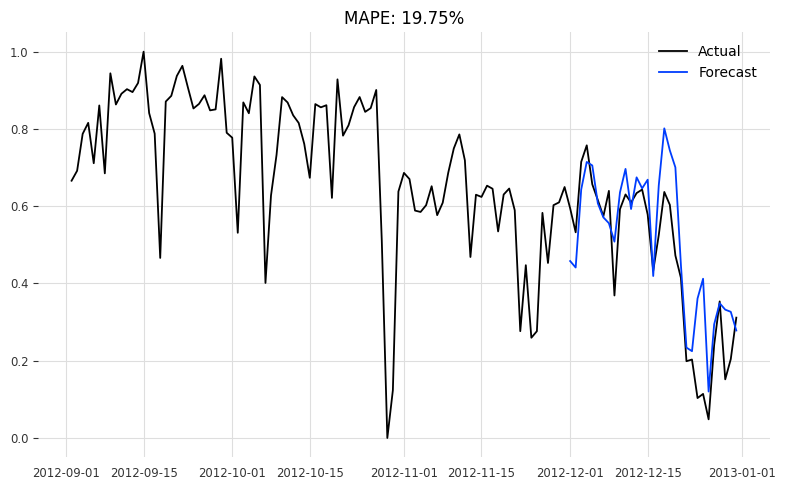

In [98]:
import matplotlib.pyplot as plt
from darts.metrics import mape

plt.figure(figsize=(8, 5))

# Plot actual values
plt.plot(series_transformed_slice.time_index, series_transformed_slice.values(), label="Actual")

# Plot forecasted values
plt.plot(pred_series.time_index, pred_series.values(), label="Forecast")

# Add title with MAPE
plt.title(f"MAPE: {mape(pred_series, val_transformed):.2f}%")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
